In [1]:
import pickle
import tempfile
import numpy as np
import tensorflow as tf
from get_data import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
MAX_SEQ_LEN = 42
EMBEDDING_DIM = 300
VOCAB_SIZE = 20000

In [86]:
data = read_data()
train_data = data[:3]
test_data = data[3:]

In [7]:
train_data, embed_matrix = preprocess_traindata(train_data, MAX_SEQ_LEN, EMBEDDING_DIM, VOCAB_SIZE)

Non labelled: 785
Contradiction: 183187
Neutral: 182764
Entailment: 183416


In [8]:
train_data[0].shape

(549367, 42)

In [9]:
train_data[1].shape

(549367, 42)

In [10]:
train_data[2].shape

(549367, 3)

In [43]:
embedding =  tf.keras.layers.Embedding(embed_matrix.shape[0], output_dim=EMBEDDING_DIM, weights=[embed_matrix], input_length=MAX_SEQ_LEN, trainable=False)

In [63]:
lam = tf.keras.regularizers.l2(l2=0.001)

In [64]:
# Define the input layers and its shapes for premise and hypothesis
premise = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype='int32')
hypothesis = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype='int32')

In [65]:
premise.shape, hypothesis.shape

(TensorShape([None, 42]), TensorShape([None, 42]))

In [66]:
# Embed the premise and hypothesis
premise_embedded = embedding(premise)
hypothesis_embedded = embedding(hypothesis)

In [67]:
premise_embedded.shape, hypothesis_embedded.shape

(TensorShape([None, 42, 300]), TensorShape([None, 42, 300]))

In [68]:
# Add a time distributed translation layer for better performance
# Time distributed layer applies the same Dense layer to each temporal slice of input
translation = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(300, activation='relu', kernel_regularizer=lam, bias_regularizer=lam))

In [69]:
# Apply the translation layer
premise_translated = translation(premise_embedded)
hypothesis_translated = translation(hypothesis_embedded)

In [70]:
premise_translated.shape, hypothesis_translated.shape

(TensorShape([None, 42, 300]), TensorShape([None, 42, 300]))

In [71]:
# Bidirectional LSTM layer
BiLSTM = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, kernel_regularizer=lam, recurrent_regularizer=lam, bias_regularizer=lam))

In [72]:
# Apply the bidirectional LSTM layer
premise_BiLSTM = BiLSTM(premise_translated)
hypothesis_BiLSTM = BiLSTM(hypothesis_translated)

In [73]:
premise_BiLSTM.shape, hypothesis_BiLSTM.shape

(TensorShape([None, 200]), TensorShape([None, 200]))

In [74]:
# Apply Batch normalization
premise_normalized = tf.keras.layers.BatchNormalization()(premise_BiLSTM)
hypothesis_normalized = tf.keras.layers.BatchNormalization()(hypothesis_BiLSTM)

In [75]:
# Concatenate the normalized premise and hypothesis and apply a dropout layer
train_input = tf.keras.layers.concatenate([premise_normalized, hypothesis_normalized])
# train_input = tf.keras.layers.Dropout(0.2)(train_input)

In [76]:
train_input.shape

TensorShape([None, 400])

In [77]:
train_input = tf.keras.layers.Dense(200, activation='tanh', kernel_regularizer=lam, bias_regularizer=lam)(train_input)
# train_input = tf.keras.layers.Dropout(0.2)(train_input)
train_input = tf.keras.layers.BatchNormalization()(train_input)

train_input = tf.keras.layers.Dense(200, activation='tanh', kernel_regularizer=lam, bias_regularizer=lam)(train_input)
# train_input = tf.keras.layers.Dropout(0.2)(train_input)
train_input = tf.keras.layers.BatchNormalization()(train_input)

train_input = tf.keras.layers.Dense(200, activation='tanh', kernel_regularizer=lam, bias_regularizer=lam)(train_input)
# train_input = tf.keras.layers.Dropout(0.2)(train_input)
train_input = tf.keras.layers.BatchNormalization()(train_input)

In [78]:
# Define the output Dense layer
prediction = tf.keras.layers.Dense(3, activation='softmax')(train_input)

In [79]:
# Define the complete model
model = tf.keras.models.Model(inputs=[premise, hypothesis], outputs=prediction)

# Choosing an optimizer
optimizer = tf.keras.optimizers.RMSprop(lr=0.01)

# Compile the model and print out the model summary
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 42, 300)      7802100     input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 42, 300)      90300       embedding_1[2][0]          

In [80]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=4, verbose=1, factor=0.5, min_lr=0.00001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

_, tmpfn = tempfile.mkstemp()
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(tmpfn, save_best_only=True, save_weights_only=True)

callbacks = [model_checkpoint, learning_rate_reduction, early_stopping]

In [81]:
# Train the model
history = model.fit(x=[train_data[0], train_data[1]], y=train_data[2], batch_size=256, epochs=25, validation_split=0.02, callbacks=callbacks)

Epoch 1/25
2104/2104 [==============================] - 181s 83ms/step - loss: 1.6960 - accuracy: 0.5857 - val_loss: 0.9175 - val_accuracy: 0.6451
Epoch 2/25
2104/2104 [==============================] - 173s 82ms/step - loss: 0.8591 - accuracy: 0.6689 - val_loss: 0.8681 - val_accuracy: 0.6588
Epoch 3/25
2104/2104 [==============================] - 172s 82ms/step - loss: 0.8109 - accuracy: 0.6847 - val_loss: 0.8015 - val_accuracy: 0.6871
Epoch 4/25
2104/2104 [==============================] - 172s 82ms/step - loss: 0.7901 - accuracy: 0.6941 - val_loss: 0.7900 - val_accuracy: 0.6928
Epoch 5/25
2104/2104 [==============================] - 172s 82ms/step - loss: 0.7722 - accuracy: 0.7026 - val_loss: 0.7711 - val_accuracy: 0.7030
Epoch 6/25
2104/2104 [==============================] - 172s 82ms/step - loss: 0.7624 - accuracy: 0.7087 - val_loss: 0.7720 - val_accuracy: 0.7013
Epoch 7/25
2104/2104 [==============================] - 172s 82ms/step - loss: 0.7551 - accuracy: 0.7119 - val_loss: 0

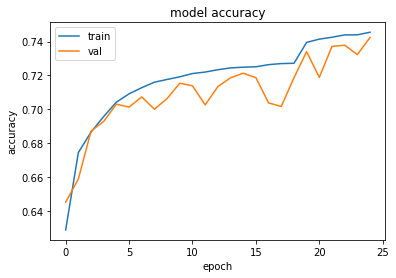

In [82]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.xticks([i for i in range(25)])
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('./figures/model_acc_0.001_0_1_100_300D_1.png')
plt.show()

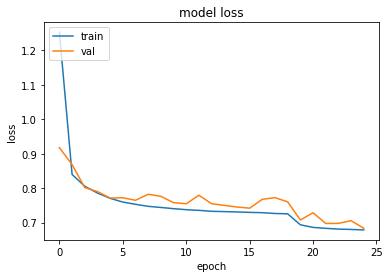

In [83]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.xticks([i for i in range(25)])
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('./figures/model_loss_0.001_0_1_100_300D_1.png')
plt.show()

In [84]:
model.save('./Trained Models/baseline_0.001_0_1_100_300D_1.h5')

In [87]:
test_data = data[3:]
test_data = preprocess_testdata(test_data, MAX_SEQ_LEN)

Non labelled: 176
Contradiction: 3237
Neutral: 3219
Entailment: 3368


In [88]:
try:
    model = tf.keras.models.load_model('./Trained Models/baseline_0.001_0_1_100_300D_1.h5')
except:
    print("Trained model does not exist. Please train the model.\n")
    exit(0)

In [89]:
loss, accuracy = model.evaluate(x=[test_data[0], test_data[1]], y=test_data[2], batch_size=256)
print("Test Loss: {:.2f}, Test Accuracy: {:.2f}%\n".format(loss, (accuracy*100)))

39/39 [==============================] - 3s 39ms/step - loss: 0.6652 - accuracy: 0.7527
Test Loss: 0.67, Test Accuracy: 75.27%



In [90]:
Y_pred = model.predict([test_data[0], test_data[1]])
Y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(test_data[2], axis=1)

In [91]:
Y_test

array([1, 2, 0, ..., 0, 2, 1], dtype=int64)

In [92]:
Y_pred

array([1, 1, 0, ..., 0, 2, 1], dtype=int64)

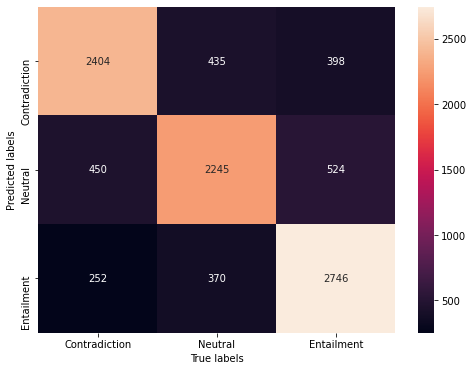

In [93]:
plt.figure(figsize=(8, 6))
ticks = ['Contradiction', 'Neutral', 'Entailment']
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='g', xticklabels=ticks, yticklabels=ticks)
plt.xlabel("True labels")
plt.ylabel("Predicted labels")
plt.savefig('./figures/model_conf_0.001_0_1_100_300D_1.png')